In [209]:
import pandas as pd


file_path = 'Länderdaten.csv'
country_data = pd.read_csv(file_path)

country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Mongolia,26.1,46.7,5.44,56.7,7710,39.20,66.2,2.64,2650
1,Sudan,76.7,19.7,6.32,17.2,3370,19.60,66.3,4.88,1480
2,Malawi,90.5,22.8,6.59,34.9,1030,12.10,53.1,5.31,459
3,Belgium,4.5,76.4,10.70,74.7,41100,1.88,80.0,1.86,44400
4,"Congo, Dem. Rep.",116.0,41.1,7.91,49.6,609,20.80,57.5,6.54,334


In [210]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     151 non-null    object 
 1   child_mort  151 non-null    float64
 2   exports     151 non-null    float64
 3   health      151 non-null    float64
 4   imports     151 non-null    float64
 5   income      151 non-null    int64  
 6   inflation   151 non-null    float64
 7   life_expec  151 non-null    float64
 8   total_fer   151 non-null    float64
 9   gdpp        151 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 11.9+ KB


In [211]:

# Dev features
# child_mort lesser is better
# health higher is better
# income higher is better
# inflation lesser is better (not negative)
# life_expec higher is better


# non dev features
# country
# exports
# imports
# total_fer
# gdpp
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,37.905960,40.447013,6.790530,46.351430,17899.423841,7.857536,70.774172,2.934305,13636.324503
std,40.749021,28.196914,2.781353,24.614163,19801.730058,10.973978,9.011529,1.512132,18766.269648
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,7.850000,22.800000,4.850000,29.950000,3850.000000,1.730000,65.450000,1.820000,1485.000000
50%,19.100000,34.800000,6.220000,43.000000,10400.000000,5.140000,73.400000,2.410000,5020.000000
75%,60.400000,50.950000,8.690000,57.500000,26200.000000,10.350000,77.000000,3.750000,16850.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [212]:
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Nachdem ich mir einen Überblick über den Datensatz verschafft habe, möchte ich nun für das Clustering die Daten vorbereiten. Dazu werde ich die Daten normalisieren und die Dimensionalität reduzieren. Zuvor werde ich versuchen zu ermitteln, wie viele Cluster ich benötige. Durch mein Vorwissen weiß ich, dass es Sinn machen könnte 3 Cluster zu bilden, da wir in unserem Alltag Länder in Entwicklungs-, Schwellen- und Industrieländer einteilen.


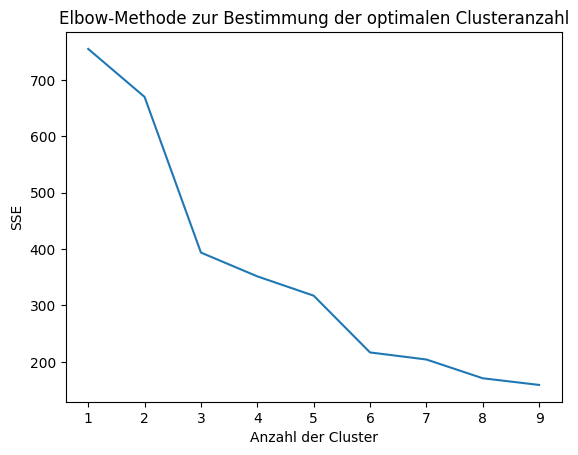

In [213]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Auswahl der relevanten Features
selected_features = country_data[['child_mort', 'health', 'income', 'inflation', 'life_expec']].copy()

# Normalisierung
scaler = StandardScaler()
normalized_selected_features = scaler.fit_transform(selected_features)

# Bestimmen der optimalen Clusteranzahl durch Elbow-Methode
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_selected_features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 10), sse)
plt.xlabel('Anzahl der Cluster')
plt.ylabel('SSE')
plt.title('Elbow-Methode zur Bestimmung der optimalen Clusteranzahl')
plt.show()

Durch Ausprobieren verschiedener random_states und Betrachtung verschiedener Möglicher Clusteranzahlen. Sehe ich einen Knick bei 3 Clustern. Daher werde ich 3 Cluster bilden.

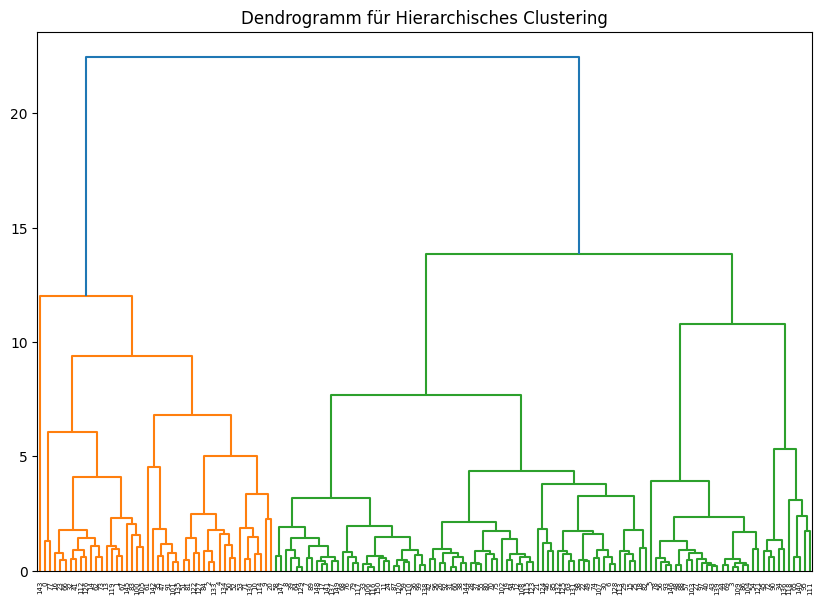

Confusion Matrix:
 [[ 1 29 18]
 [ 6  3 55]
 [39  0  0]]
Label Mapping:
 [2 0 1]


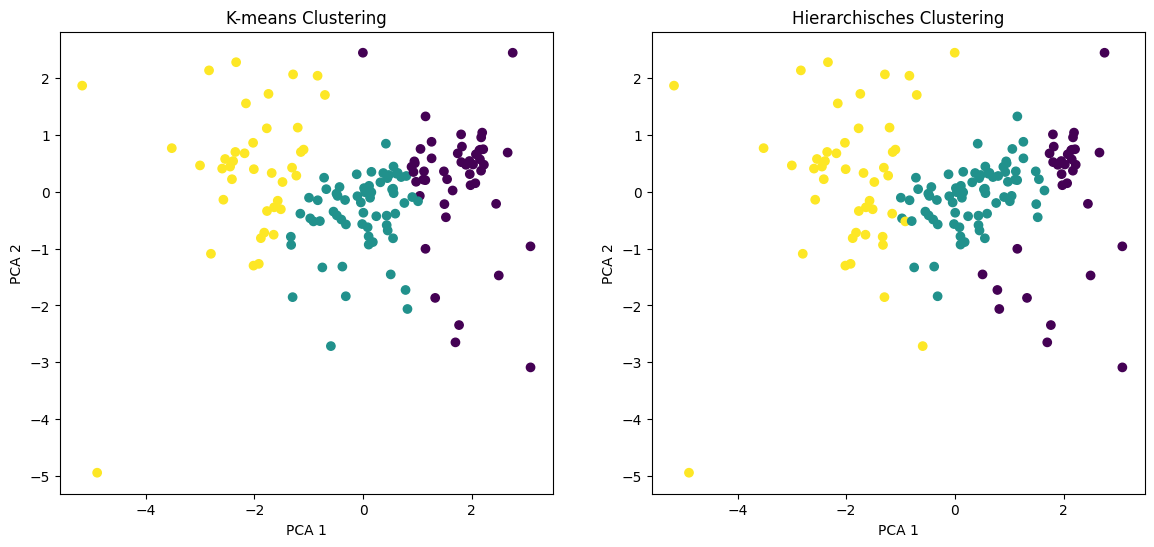

In [214]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import numpy as np

# K-means Clustering mit 3 Clustern
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(normalized_selected_features)

# Hierarchisches Clustering
linkage_matrix = linkage(normalized_selected_features, method='ward')
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters)
hierarchical_labels = hierarchical.fit_predict(normalized_selected_features)

# Dendrogramm
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogramm für Hierarchisches Clustering')
plt.show()

# Zuordnung der Hierarchischen und K-Means Labels. Damit die Cluster vergleichbar sind.
conf_matrix = confusion_matrix(kmeans_labels, hierarchical_labels)
map_labels = np.argmax(conf_matrix, axis=0)
mapped_hierarchical_labels = np.array([map_labels[label] for label in hierarchical_labels])

print("Confusion Matrix:\n", conf_matrix)
print("Label Mapping:\n", map_labels)

# PCA für 2D-Visualisierung
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_selected_features)

plt.figure(figsize=(14, 6))

# K-means Clustering
plt.subplot(1, 2, 1)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Hierarchisches Clustering
plt.subplot(1, 2, 2)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=mapped_hierarchical_labels, cmap='viridis')
plt.title('Hierarchisches Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()


Spätestens fällt hier auf, dass es Ausreißer gibt. Diese werde ich jedoch nicht entfernen, da ich bereits einen kleinen Datensatz habe und durch das Entfernen von Ausreßern eventuell meine Analyse verfälschen könnte.

Nun werde ich versuchen mir diese Cluster anhand ihrer Werte und Eigenschaften anzuschauen, um diese zu identifizieren.

In [215]:
# Zuordnung der Cluster-Labels zu den ursprünglichen Daten
country_data['Cluster'] = kmeans_labels

# numerischen Spalten
numerical_columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Berechnung der Mittelwerte
cluster_characteristics = country_data.groupby('Cluster')[numerical_columns].mean()

cluster_characteristics

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,6.962500,53.537500,8.757083,51.339583,37695.000000,2.710917,79.033333,1.787708,33891.458333
1,25.375000,37.996703,5.567656,44.238530,11720.312500,9.218266,72.142188,2.539062,5677.906250
2,96.553846,28.356667,6.376923,43.679487,3675.717949,11.958846,58.364103,4.994103,1766.897436


Cluster 0: Dieses Cluster bildet entwickelte Länder ab. Entsprechen Womöglich Industriestaaten.
- niedrigste Kindersterblichkeit
- höchte Lebenserwartung
- niedrigste Fruchtbarkeitsrate
- höchste Gesundheit
- höchste Einkommen
- höchste GDP
- höchste Exporte
- höchste Importe
- geringste Inflation

Cluster 2: Dieses Cluster bildet Entwicklungsländer ab, mit den schlechtesten Entwicklungswerten.
- höchste Kindersterblichkeit
- niedrigste Exporte
- mittlere Gesundheit
- niedrigste Importe
- niedrigste Einkommen
- höchste Inflation
- geringste Lebenserwartung
- höchste Fruchtbarkeitsrate
- niedrigstes GDP


Cluster 1: Dieses Cluster bildet Schwellenländer ab. Mit mittleren Werten bzw. Werten, die in einigen Punkten Entwicklungsländern ähneln und in anderen Industriestaaten.
- meisten Werte zwischen Cluster 0 und Cluster 2



In [216]:
# Zuordnung der K-means und hierarchischen Cluster-Labels zu den Ländern
country_data['KMeans_Cluster'] = kmeans_labels
country_data['Hierarchical_Cluster'] = mapped_hierarchical_labels

# Ausgabe der Länder für jeden K-means Cluster
print("Länder im K-means Cluster 0:")
print(country_data[country_data['KMeans_Cluster'] == 0]['country'].values)

print("\nLänder im K-means Cluster 1:")
print(country_data[country_data['KMeans_Cluster'] == 1]['country'].values)

print("\nLänder im K-means Cluster 2:")
print(country_data[country_data['KMeans_Cluster'] == 2]['country'].values)

# Ausgabe der Länder für jeden hierarchischen Cluster
print("\nLänder im Hierarchischen Cluster 0:")
print(country_data[country_data['Hierarchical_Cluster'] == 0]['country'].values)

print("\nLänder im Hierarchischen Cluster 1:")
print(country_data[country_data['Hierarchical_Cluster'] == 1]['country'].values)

print("\nLänder im Hierarchischen Cluster 2:")
print(country_data[country_data['Hierarchical_Cluster'] == 2]['country'].values)



Länder im K-means Cluster 0:
['Belgium' 'United States' 'Slovak Republic' 'Panama' 'Bahamas' 'Slovenia'
 'Hungary' 'Lebanon' 'United Kingdom' 'Italy' 'France'
 'United Arab Emirates' 'Portugal' 'Micronesia, Fed. Sts.' 'Norway'
 'Sweden' 'New Zealand' 'Bosnia and Herzegovina' 'Kuwait' 'Cyprus'
 'Germany' 'Malta' 'Ireland' 'South Korea' 'Denmark' 'Greece' 'Chile'
 'Australia' 'Singapore' 'Japan' 'Iceland' 'Canada' 'Croatia' 'Austria'
 'Luxembourg' 'Poland' 'Israel' 'Qatar' 'Switzerland' 'Bahrain' 'Uruguay'
 'Spain' 'Brunei' 'Barbados' 'Finland' 'Costa Rica' 'Montenegro'
 'Czech Republic']

Länder im K-means Cluster 1:
['Mongolia' 'Bolivia' 'Turkey' 'Georgia' 'Belize' 'Belarus' 'Indonesia'
 'Morocco' 'Timor-Leste' 'Fiji' 'Russia' 'Samoa' 'China' 'Iran' 'Egypt'
 'Tunisia' 'Libya' 'Jamaica' 'Paraguay' 'Brazil' 'Guatemala' 'Iraq'
 'Guyana' 'Armenia' 'Mauritius' 'Albania' 'Myanmar' 'Nepal' 'Jordan'
 'Peru' 'Oman' 'Turkmenistan' 'Philippines' 'Thailand' 'Venezuela'
 'Malaysia' 'Sri Lanka' 'Ukr

Empfehlung an den CEO:

Cluster 0: Diese Länder sind bereits gut entwickelt und haben eine hohe Lebensqualität. Hier könnten Investitionenn in Bildung und Forschung sinnvoll sein, um durch Innovationen den bestehenden Vorpsrung zu halten. Gezielte Investitionen in länderspezifische Projekte könnten hier besonders effektiv sein. Frühbildung in der Kita, Schulressourcen erhöhen oder Infrastrukturprojekte zur besseren Bildung und Koorperationen in der Forschun könnten hier sinnvoll sein.

Cluster 1: Diese Länder sind auf einem guten Weg. Sie haben bereits gezeigt, dass sie in einigen Punkten bereits gut entwickelt sind, jedoch gibt es Punkte, wo sie ähnlich schlecht sind wie Entwicklungsländer. Eine gezielt Investition in diesen unterentwickelten Punkten würde die Allgemeine Entwicklung dieser Länder besonders fördern. 
Investitionen besonders in die Wirtschaft und das Gesundheitssystem könnten hier sinnvoll sein, um die rückständigen Punkte aufzuholen.

Cluster 2: Diese Länder sind am schlechtesten entwickelt und benötigen dringend Hilfe. Hier könnten Investitionen in die Gesundheit und Bildung besonders sinnvoll sein. Diese Investitionen würden nachhaltig die Lebensqualität dieser Länder verbessern. Dies kann allerdings nur durch eine langfristige Zusammenarbeit funktionieren. Da die zu aufholenden Punkte sehr groß sind, ist es wichtig, dass die Investitionen langfristig angelegt sind und nicht nur kurzfristig. Entsprechend wären die Ergebnisse der Investitionen auch erst langfristig sichtbar. Ein grundlegendes Fundament, wäre hier die Bildung und Gesundheitssysteme, um wirtschaftliche Vorraussetzungen für Wachstum zu schaffen.